<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic comments classification**
![](https://techcrunch.com/wp-content/uploads/2013/06/hatespeech-tilt.jpg?w=200&crop=1)

Terms:
* NLP: **N**atural **L**anguage **P**rocessing 
* tokens: terms or words,
* tokenize = splitting a comment into the component words
* corpus: a collection of documents/sentence
* NLTK: **N**atural **L**anguage **T**ool**k**it

Assumptions:
* Which word embedding methodology to use? BOW (Bag Of Word),Word2Vec,Doc2Vec,  FastText,TFIDF 
* Word2Vec: use a trained model instead of training on this limied dataset.
* Strategy\plan how to clean the vocabulary
* Derive direct feaures from the text
* Classification of 6 categories

Pre-processing:
* Convert comments strings to lowercase
* decide if to replace \n by space or period
* remove words that have numbers inside them
* remove any other non letter charachter

Text clean:
* Multiple spaces
* Usernames
* email addresses
* '=', '-',
* IP addresses
* DateTime
* Comments that are less than 4 charachters
* Names (words that start with capital at middle of sentence)




In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import scipy
from scipy import stats
import re
import sys
import tensorflow as tf
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding; to visualize high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud, STOPWORDS
! pip install nltk
import nltk #natural language tool kit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
!pip install replacer #replace with regex

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For the dimensionality reduction
from sklearn.feature_selection import SelectKBest , f_classif, VarianceThreshold

# essential tools for lsa
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics.pairwise import cosine_similarity
#other imports
from os import listdir

# For the tree models
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [100]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving test.csv to test.csv


Get the data

In [6]:
traincomments=pd.read_csv('train10000.csv')
# traincomments.head()
traincomments.info()
# traincomments.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10000 non-null  object
 1   comment_text   10000 non-null  object
 2   toxic          10000 non-null  int64 
 3   severe_toxic   10000 non-null  int64 
 4   obscene        10000 non-null  int64 
 5   threat         10000 non-null  int64 
 6   insult         10000 non-null  int64 
 7   identity_hate  10000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 625.1+ KB


Add columns

In [0]:
traincomments['number_categories']= traincomments.iloc[:, 2:8].sum(axis=1) # categories count
traincomments['any_category']= traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].max(axis=1)
traincomments['exclamation_mark_count']=traincomments['comment_text'].str.count('!') # count '!'
def find_exclamation_mark_consecutive(x):
    n = 0
    matches = re.findall(r'[!]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n
traincomments['exclamation_mark_consecutive']=traincomments['comment_text'].apply(lambda x: find_exclamation_mark_consecutive(str(x)))
traincomments['question_mark_count']=traincomments['comment_text'].str.count('\?') # count '?'
def find_question_mark_consecutive(x): 
    n = 0
    matches = re.findall(r'[?]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n 
traincomments['question_mark_consecutive']=traincomments['comment_text'].apply(lambda x:find_question_mark_consecutive(str(x))) 
traincomments['comment_characters']=traincomments['comment_text'].str.len() #count characters
traincomments['comment_words']=traincomments['comment_text'].str.split().str.len() # count words
traincomments['comment_short']=traincomments['comment_text'].apply(lambda x: len(str(x))<=100) # number of characters less than 100
#Sentense count in each comment:
    #use '\n' to count the number of sentences in each comment #?,!,.; (list)
# traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(re.findall("\n",str(x)))+1)
traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(nltk.tokenize.sent_tokenize(str(x))))
traincomments['count_unique_word']=traincomments.comment_text.apply(lambda x: len(set(str(x).split()))) # count unique words
#count upper case words:
traincomments["count_words_upper"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#count title case words:
traincomments["count_words_title"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords:
eng_stopwords = set(stopwords.words("english"))
traincomments["count_stopwords"] =traincomments.comment_text.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words:
traincomments["mean_word_len"] = traincomments.comment_text.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#if there is any word with all upper:
# traincomments['all_upper']=traincomments['comment_text'].str.split().apply(lambda x: np.any([True if w.isupper() else False for w in x]))
traincomments['begins_greeting'] = traincomments['comment_text'].apply(lambda x: True if re.match('^hey|hi|hello', str(x), re.IGNORECASE) else False)
traincomments['begins_I'] = traincomments['comment_text'].apply(lambda x: True if re.match('^I ', str(x), re.IGNORECASE) else False)
traincomments['begins_You'] = traincomments['comment_text'].apply(lambda x: True if re.match('^You', str(x), re.IGNORECASE) else False)
traincomments['begins_capital'] = traincomments['comment_text'].apply(lambda x: True if re.match('^[A-Z].*', str(x)) else False)
traincomments['contains_parenthesis'] = traincomments['comment_text'].apply(lambda x: True if re.search('\(|\)', str(x)) else False)
traincomments['contains_curse'] = traincomments['comment_text'].apply(lambda x: True if re.search('fuck|shit |ass| looser | dick|bitch|suck|Nazi|stupid|bullshit| piss | cock|jew| die | cunt| rape | gay | nigger | pussy|wank|faggot|dumb| crap | slut ', str(x),re.IGNORECASE) else False)
traincomments['contains_curse_replacement'] = traincomments['comment_text'].apply(lambda x: True if re.search('A$$HOLE|NIGGA|FVCK|cra*p|fxxk|b*tch', str(x),re.IGNORECASE) else False)
traincomments['contains_negative_terms'] = traincomments['comment_text'].apply(lambda x: True if re.search(' bad | terrible | kill | block | stop | wrong | destroy | absurd | don\'t | mom | mother | fat | cut | burn | ugly | kick | liar ', str(x),re.IGNORECASE) else False)
traincomments['contains_polite_words'] = traincomments['comment_text'].apply(lambda x: True if re.search('thanks|thank you|sorry|welcome', str(x),re.IGNORECASE) else False)
traincomments['contains_abbreviations'] = traincomments['comment_text'].apply(lambda x: True if re.search(' OMG | LMAO |WTF|FFS', str(x),re.IGNORECASE) else False)
def isEnglish(s): # look for sentences that have non English charachters such as významu, 通, ފުރަތަމަ
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return True
    else:
        return False
traincomments['contains_nonenglish'] = traincomments['comment_text'].apply(lambda x: isEnglish(x))

# **Data Exploration:**

In [8]:
# traincomments.shape
traincomments.nunique()
# traincomments.info()
# traincomments.describe()
# print(traincomments.obscene.value_counts())
# print(traincomments.threat.value_counts())
# print(traincomments.insult.value_counts())
# print(traincomments.identity_hate.value_counts())
# print(traincomments.toxic.value_counts())
# print(traincomments.severe_toxic.value_counts())

id                              10000
comment_text                     9980
toxic                               2
severe_toxic                        2
obscene                             2
threat                              2
insult                              2
identity_hate                       2
number_categories                   7
any_category                        2
exclamation_mark_count             41
exclamation_mark_consecutive       24
question_mark_count                23
question_mark_consecutive          13
comment_characters               1571
comment_words                     524
comment_short                       2
count_sentences                    66
count_unique_word                 348
count_words_upper                  80
count_words_title                 140
count_stopwords                   317
mean_word_len                    4034
begins_greeting                     2
begins_I                            2
begins_You                          2
begins_capit

The data does not contain missing values

# **Preliminary EDA**

,count,label
threat,33,threat
identity_hate,84,identity_hate
severe_toxic,101,severe_toxic
insult,494,insult
obscene,527,obscene
toxic,971,toxic
none,8970,none


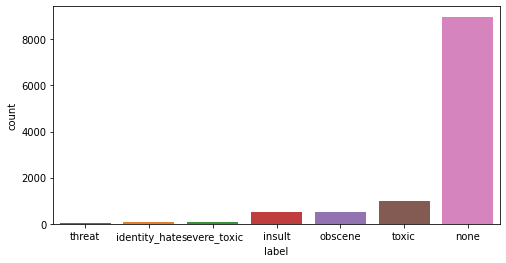

In [9]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
traincomments['none'] = (traincomments['any_category']== 0).astype(int)
COLUMNS.append('none')
df_distribution = traincomments[COLUMNS].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
df_distribution['label']=df_distribution.index
fig = plt.figure()
fig.set_size_inches(8,4)
sns.barplot(x='label', y='count', hue=None, data=df_distribution, order=None, hue_order=None);
df_distribution

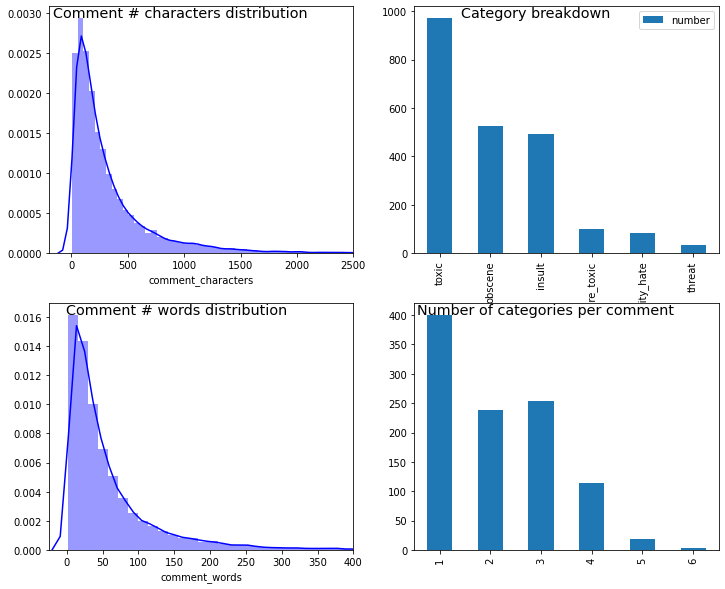

In [10]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.43, y=0.93, ha='center', fontsize='x-large');
ax2.set_title("Category breakdown", x=0.4, y=0.93, ha='center', fontsize='x-large');
ax3.set_title("Comment # words distribution", x=0.42, y=0.93, ha='center', fontsize='x-large');
ax4.set_title("Number of categories per comment", x=0.43, y=0.93, ha='center', fontsize='x-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,2500)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,400)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()


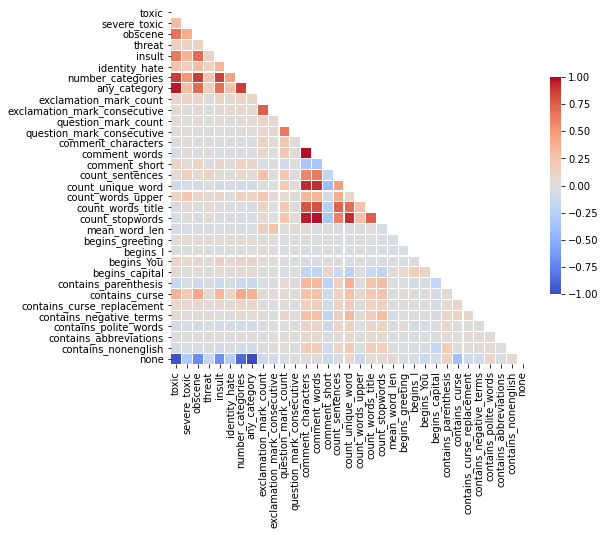

In [11]:
# corr_df = traincomments[traincomments['number_categories']>0]
corr_df = traincomments
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=False, mask=mask, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 7},cmap='coolwarm'); #

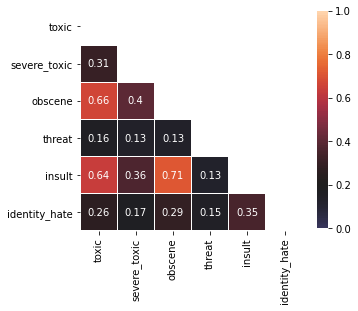

In [12]:
corr_df =traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, mask=mask, vmax=1,vmin=0, center=0.2,
            square=True, linewidths=.2, cbar_kws={"shrink": .8}, annot_kws={"size": 10});

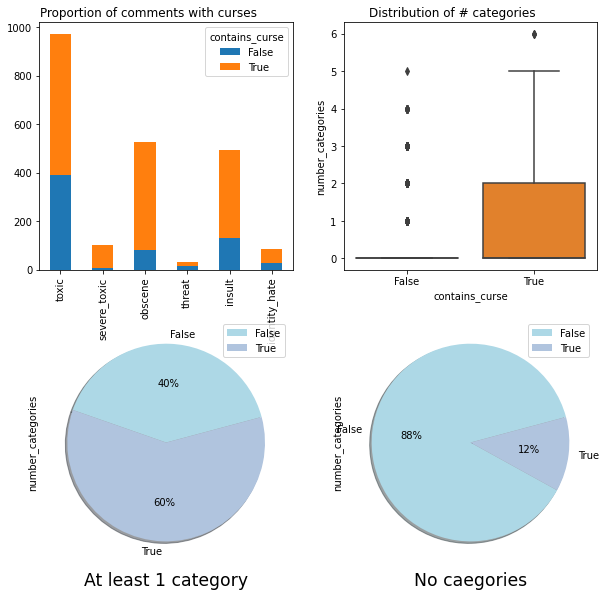

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.set_size_inches(10,10)
curse_proportion=traincomments.groupby('contains_curse').agg({'toxic':'sum','severe_toxic':'sum','obscene':'sum','threat':'sum','insult':'sum','identity_hate':'sum'}).transpose()
curse_proportion.plot.bar(stacked=True, ax=ax1);
sns.boxplot(x='contains_curse', y='number_categories', hue=None, data=traincomments, order=None, hue_order=None, ax=ax2);
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
traincomments[traincomments['any_category']==1].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax3)
traincomments[traincomments['any_category']==0].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax4)
ax3.set_title('At least 1 category', x=0.5, y=-0.1, ha='center', fontsize='xx-large');
ax4.set_title('No caegories', x=0.5, y=-0.1, ha='center', fontsize='xx-large');
traincomments[['contains_curse','number_categories']].groupby('contains_curse').describe()

ax1.set_title("Proportion of comments with curses", x=0.43, y=1, ha='center', fontsize='large');
ax2.set_title("Distribution of # categories", x=0.43, y=1, ha='center', fontsize='large');

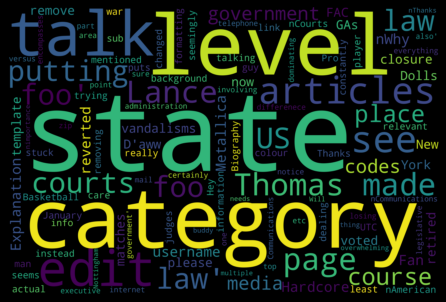

In [14]:
text = traincomments['comment_text'].values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 6), facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Initial Cleanning & Tokenizing**

In [0]:
words_with_numbers_pattern = re.compile(r'\w*[\d]+\w*') # letter\s (0 or more), digit (1 or more), letter\s (0 or more)
special_chars_pattern = re.compile(r'[_,."!?:;=&*\\/()\'$^#]+')
def clean(s):
    s = re.sub(words_with_numbers_pattern, '', s).strip()  # get rid of numbers or words with numbers 
    s = re.sub(special_chars_pattern, '', s)  # remove special chars without removing words
    # ''.join([char.strip(',."!?:;=&*\\/()\'$^#') for char in s])  # remove these characters - this is so slow-- change to re
    return s

In [16]:
traincomments_filtered  = traincomments[(traincomments['comment_words']<300)&(traincomments['comment_characters']<2000)&(traincomments['contains_nonenglish']==False)]
comment_list = traincomments_filtered['comment_text'].values # gives a list of all comments (each is a string)
comment_list_lower=list(map(lambda x:x.lower(),comment_list))
# sentences_list = [re.split('[.\n!?]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
comment_list_lower_splitline = [re.split('[\n]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
splitline_flatten = [s for sentence in comment_list_lower_splitline for s in sentence] # gives a list of all sentences (i.e. the comments that we split only by \n)
sentences_list = list(map(lambda x:nltk.sent_tokenize(x),splitline_flatten))
sentences_flat = [s for sentence in sentences_list for s in sentence] # gives a list of all sentences; we loose the comment context
sentences_clean = [clean(s) for s in sentences_flat if len(s) > 1]
words_within_sentences = [s.split() for s in sentences_clean] # list of list; words within sentences
sentences = [words_list for words_list in words_within_sentences if len(words_list)>1] # remove lists with 1 word or less

#remove non-english words
nltk.download('words')
words = set(nltk.corpus.words.words())
#" ".join(w for w in nltk.wordpunct_tokenize(traincomments['comment_text']) \
#         if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## **Word2Vec**

### ***Train Word2Vec Model***

In [0]:
sentences_word2vec = sentences.copy()
word2vec_data = traincomments.copy()
model = Word2Vec(sentences_word2vec, size=100, window=5, min_count=3, workers=4) # train the model
len(model.wv.vocab) #how many words in the vocabulary

8664

### **Word similarity examples**

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


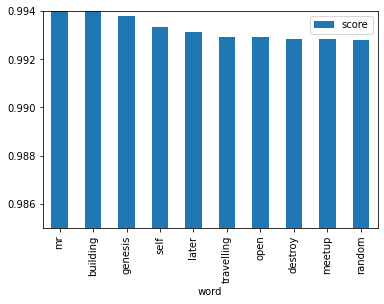

In [0]:
sims=model.wv.most_similar('kill');
sims_df=pd.DataFrame(data=sims, columns=['word','score']);
sims_df.sort_values(by='score',ascending=False).plot.bar('word','score',ylim=(0.985,0.994));

### **Build Word2Vec vocabulary:**

In [0]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()] # build a list of the terms and count
ordered_vocab_sorted = sorted(ordered_vocab, key=lambda k: -k[2]) # sort by the term counts, most common appear first
ordered_terms, term_indices, term_counts = zip(*ordered_vocab_sorted) # unzip the terms, integer indices, and counts into separate lists
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms) # create a DF: vectors (data); terms (index)
word_vectors.sample(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
margin,0.008863,0.063144,-0.023597,-0.005573,0.117537,0.073941,-0.093401,0.039695,0.060551,-0.042211,-0.114319,0.039632,0.061862,0.079390,-0.054621,0.044727,0.009888,0.132666,0.163838,0.081468,-0.003697,0.050568,-0.040013,0.000996,0.298442,-0.048896,0.067277,-0.050616,0.053765,0.075339,-0.033844,0.059461,-0.057123,0.024438,0.091280,-0.112454,0.034443,-0.057100,-0.129068,-0.137251,...,0.009042,0.053497,0.055930,0.292228,-0.015970,-0.092862,0.174623,0.090998,0.046283,-0.043392,0.000273,-0.102478,-0.159378,0.056404,-0.106921,-0.184134,-0.204872,-0.068120,0.098058,-0.045520,0.065163,0.108117,0.144651,0.150434,-0.095669,0.194938,-0.019492,0.169758,-0.105002,-0.003367,0.097503,-0.075845,-0.014227,-0.312610,-0.042073,-0.038568,-0.009074,-0.019367,0.094428,-0.105738
maintains,-0.017885,0.119002,-0.023743,0.011572,0.082930,0.061730,-0.099932,0.062685,0.014203,-0.085161,-0.090053,0.026849,0.098770,0.085701,-0.071553,0.068726,-0.002840,0.134227,0.135412,0.155174,-0.051341,0.034931,-0.023886,-0.011991,0.254340,-0.060280,0.074223,-0.034745,-0.001186,0.072149,-0.023910,0.080849,-0.044209,0.068300,0.091613,-0.075652,0.056819,-0.015130,-0.105689,-0.120745,...,-0.015721,0.038699,-0.013671,0.268416,-0.004567,-0.072631,0.177387,0.063842,0.097611,-0.059002,-0.028138,-0.125329,-0.201933,0.027333,-0.086980,-0.226996,-0.166318,-0.013284,0.120537,-0.024610,0.074566,0.097397,0.118609,0.183200,-0.024539,0.200910,-0.032137,0.176818,-0.162302,-0.035740,0.136228,-0.062749,0.002525,-0.256066,0.008908,-0.059898,-0.070020,-0.056639,0.108063,-0.148384
closing,-0.050126,0.161294,-0.032851,-0.005258,0.156811,0.050057,-0.092753,0.064992,0.009131,-0.130308,-0.144659,0.023563,0.095999,0.062184,0.009553,0.075271,0.076405,0.124184,0.157560,0.134524,0.027818,0.011304,-0.029601,0.011717,0.310259,-0.060396,0.062708,-0.040016,0.035119,0.105771,-0.021688,0.051750,-0.033476,-0.004225,0.070912,-0.060736,0.015644,-0.081621,-0.107936,-0.168204,...,0.088052,0.015551,0.094292,0.288396,0.003191,-0.082852,0.163367,0.102893,-0.014677,-0.079734,-0.010152,-0.103898,-0.169344,0.039951,-0.072989,-0.204500,-0.146026,-0.038426,0.133313,-0.047978,0.057522,0.130661,0.112286,0.100793,-0.031452,0.182868,-0.030566,0.154039,-0.112303,0.023825,0.140645,-0.100843,-0.032327,-0.252613,0.033918,-0.079817,-0.041237,-0.049821,0.073354,-0.053802
lava,-0.005343,0.101734,-0.022893,0.003511,0.099365,0.082566,-0.074612,0.026723,0.014771,-0.089984,-0.100035,0.048565,0.112338,0.086982,-0.026094,0.046952,0.047571,0.162708,0.126551,0.122167,-0.044754,0.039539,-0.014917,0.018215,0.262072,-0.047033,0.096884,-0.072007,-0.006974,0.075326,-0.031917,0.093010,-0.020607,0.051557,0.123628,-0.078565,0.065962,-0.041707,-0.077521,-0.129797,...,-0.023240,0.044574,0.021077,0.262271,0.016629,-0.092935,0.210624,0.082699,0.089108,-0.070585,-0.028751,-0.105225,-0.210951,0.056525,-0.077433,-0.192609,-0.150593,-0.041293,0.103008,-0.053651,0.073852,0.102556,0.120630,0.181593,-0.021166,0.190000,-0.011005,0.154216,-0.151026,-0.048476,0.151404,-0.050160,0.007299,-0.287897,-0.007161,-0.031486,-0.077154,-0.039223,0.082756,-0.131496
automatically,-0.012502,0.155656,-0.097104,0.017598,0.153055,0.058381,-0.116986,0.065272,-0.039777,-0.129227,-0.092433,-0.055888,0.086285,0.085568,0.022950,0.038352,-0.055406,0.107574,0.087717,0.025930,0.077806,0.048817,-0.106831,0.011183,0.284013,-0.062553,0.053879,-0.016300,0.011440,0.131248,-0.031966,0.110225,-0.027094,-0.017646,0.002250,-0.165767,-0.058654,-0.011221,-0.174413,-0.136795,...,0.038779,0.098504,0.078742,0.242211,-0.033770,-0.082157,0.100852,0.136888,0.044373,-0.035885,-0.006613,-0.093382,-0.121904,0.021755,-0.034010,-0.132452,-0.136043,-0.089167,0.004161,-0.082017,0.069892,0.229165,0.189005,0.100973,-0.151846,0.157056,-0.014990,0.221230,-0.079062,-0.026671,0

## **TSNE**
t-distributed stochastic neighbor embedding

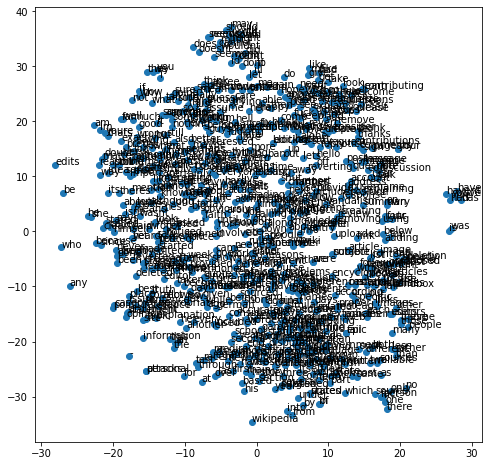

In [0]:
X = word_vectors[:700].to_numpy() # will use top most frequent
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=word_vectors[:700].index.tolist(), columns=['x', 'y'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

### **add vector per comment to training df**
need to clean comment_list before this

In [0]:
wvc=word_vectors.columns.tolist()
cols=word2vec_data.columns.tolist()
cols.extend(wvc)
word2vec_data=word2vec_data.reindex(columns=cols)
for i, comment in enumerate(comment_list):
    org_words = clean(comment).split()
    words = [w for w in org_words if w in word_vectors.index]  #remove words not in model
    comment_vector=word_vectors.loc[words].mean(axis=0)   # average the word vectors for the comment (cum then normalize for word nmber)
    word2vec_data.loc[i, wvc]=comment_vector  # add the features to the df
word2vec_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,contains_nonenglish,none,0,1,2,3,4,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,False,1,-0.113928,0.080029,-0.047002,0.002805,-0.060823,...,-0.033514,-0.036203,0.006891,-0.102868,0.018648,-0.022877,0.043518,0.030606,0.006347,0.011104,-0.064361,0.005213,-0.198748,0.194756,-0.128127,0.139145,0.051855,0.118351,-0.000978,0.030844,0.017314,-0.006260,0.063514,-0.043627,0.058103,0.071306,0.031050,-0.111389,0.013033,-0.008102,-0.035370,0.020911,-0.122999,0.005552,0.008675,0.000697,-0.062627,-0.160950,0.077858,-0.083513
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,False,1,-0.109891,0.078501,-0.057323,-0.010552,-0.056994,...,-0.032242,-0.030818,0.021337,-0.120803,0.052746,-0.005755,0.040784,-0.016192,0.032628,0.011340,-0.097836,0.010876,-0.234915,0.234926,-0.131431,0.157448,0.059237,0.146994,0.022869,0.036837,0.018126,-0.005870,0.084711,-0.044755,0.061686,0.087907,0.065156,-0.139217,0.038136,-0.015655,-0.008283,0.035837,-0.135829,0.041150,0.000686,0.011651,-0.101587,-0.202235,0.098055,-0.091738
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,False,1,-0.100005,0.087128,-0.065688,-0.013017,-0.088538,...,-0.043199,-0.029647,0.028188,-0.111906,0.054528,0.007999,0.015638,0.003082,0.007141,0.000967,-0.093583,0.033287,-0.199560,0.224887,-0.103851,0.134331,0.079767,0.123892,0.005869,0.013909,0.016789,-0.045457,0.069476,-0.027832,0.070517,0.115999,0.038385,-0.118158,0.060097,-0.003581,0.004021,0.013707,-0.116825,0.027912,0.011471,0.021452,-0.092785,-0.152288,0.077628,-0.091343
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,False,1,-0.120335,0.065116,-0.060692,-0.009372,-0.082007,...,-0.050208,-0.023323,0.016287,-0.110830,0.045073,0.000197,0.012145,0.011508,0.012334,-0.002283,-0.087385,0.019401,-0.185304,0.195784,-0.129568,0.130223,0.085350,0.089529,0.029673,0.013700,0.033195,-0.024487,0.063838,-0.040216,0.059218,0.114902,0.033480,-0.137854,0.037606,0.017580,0.005179,0.013503,-0.135491,0.031776,0.029572,0.016014,-0.092528,-0.140670,0.081094,-0.098900
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,False,1,-0.148455,0.098465,-0.066620,0.005350,-0.098092,...,-0.071434,-0.041933,-0.002854,-0.106646,0.071464,-0.013137,0.013100,0.025859,0.004491,-0.000622,-0.095244,0.020150,-0.197636,0.225014,-0.130204,0.121469,0.084597,0.120584,-0.034416,0.027436,-0.010761,-0.048179,0.058384,-0.012349,0.049410,0.113431,0.025666,-0.090957,0.025223,-0.015953,-0.024352,0.020428,-0.092405,0.010227,-0.001874,0.013854,-0.075787,-0.162395,0.072013,-0.110950


# **TF IDF** (Term Frequency – Inverse Document Frequency)

* **Term Frequency**: how often a given word appears within the evaluated text.
* ** Document Frequency**: how often a given word appears within the corpus

TF-IDF highlights words that are more interesting, i.e. frequent in the text but not in the corpus. The higher the TFIDF score, the rarer the term is.

process: 
1. stopword cleanning
2. stemming (go, goes, going = go)/lemmatizing (he,she,it= do)
3. clean "junk"
4. vectorizer (take the corpus and convert each doc/sentence into a sparse matrix of TFIDF)
5. LSA (dimentionality reduction)

###**Cleaning** **preprocessing**

In [0]:
replacement_patterns = [(r'won\'t', 'will not'),(r'can\'t', 'cannot'),(r'i\'m', 'i am'),(r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),(r'(\w+)\'d', '\g<1> would'),] #cleanning:

def strip_symbols(text):
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

class RegexpReplacer(object):
   def __init__(self, patterns=replacement_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
           s = re.sub(pattern, repl, s)
      return s

from nltk.stem import WordNetLemmatizer #stemmig:
lemma = []
wnl = WordNetLemmatizer()
for sen in traincomments['comment_text']:
    tokens = [wnl.lemmatize(w) for w in sen]
    lemma.append(tokens)

# Removing Stopwords
filter_words = []
Stopwords = set(stopwords.words('english'))
Stopwords.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

#ab = spell('nd')
for sent in lemma:
    tokens = [w for w in sent if w not in Stopwords]
    filter_words.append(tokens)

space = ' ' 
for sentence in filter_words:
    sentences.append(space.join(sentence))

replacer=RegexpReplacer()
traincomments['comment_text_tfidf'] = traincomments['comment_text'].apply(lambda x:replacer.replace(x))
traincomments['comment_text_tfidf'] = traincomments['comment_text_tfidf'].apply(lambda x:strip_symbols(x))
traincomments['comment_text_tfidf'] = traincomments['comment_text_tfidf'].apply(lambda x:clean(x))

### **Deploy TF IDF vectorizer:**

In [18]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words = 'english',max_features=1000, min_df=3, max_df = 100)  # TFIDF
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(traincomments['comment_text_tfidf']) # fit_transform
df_1st_comm_vecs = pd.DataFrame(tfidf_vectorizer_vectors[1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) #place tf-idf values in df
df_1st_comm_vecs.sort_values(by=["tfidf"],ascending=False) # print vectors of 1st comment as example

,tfidf
background,0.714739
january,0.699391
posts,0.000000
png,0.000000
pointed,0.000000
...,...
file,0.000000
files,0.000000
film,0.000000
final,0.000000


In [19]:
tfidf_vectorizer.get_feature_names()[0:10]

['ability',
 'absolutely',
 'abuse',
 'academic',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accounts',
 'accurate']

In [20]:
list(tfidf_vectorizer.vocabulary_.items())[0:10] # dictionary of term and location in the matrix

[('explanation', 316),
 ('username', 941),
 ('fan', 329),
 ('york', 996),
 ('background', 84),
 ('january', 468),
 ('suggestions', 877),
 ('types', 922),
 ('exact', 303),
 ('format', 356)]

In [21]:
terms = tfidf_vectorizer.get_feature_names()
sums = tfidf_vectorizer_vectors.sum(axis=0) # sum tfidf frequency of each term through documents
data = [] # connecting term to its sums frequency
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

           term       rank
89       banned  40.972900
814        shit  40.498218
995        yeah  40.439232
478        july  39.531329
382         god  38.515814
..          ...        ...
176  cocksucker   2.271854
419    homeland   2.234106
515        lion   2.125364
291        epic   2.043494
910       towns   1.381390

[1000 rows x 2 columns]


### **TF IDF dimensionality reduction: LSA** (**L**atent **S**emantic **A**nalysis)
to 100 features; by means of **SVD** (truncated **S**ingular **V**alue **D**ecomposition)

In [60]:
lsa = TruncatedSVD(n_components=10, algorithm = 'arpack')
lsa = lsa.fit_transform(tfidf_vectorizer_vectors)
lsa

array([[ 0.09770778,  0.01051305,  0.17928516, ..., -0.00519662,
         0.00715629, -0.0071824 ],
       [ 0.03942296,  0.00718347,  0.00319186, ..., -0.01244284,
        -0.01165517,  0.00797483],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04149938, -0.01169104, -0.00512504, ..., -0.01273092,
        -0.01770286,  0.01201453],
       [ 0.11950929, -0.01693417, -0.02109873, ..., -0.02582793,
        -0.0612421 ,  0.01505641],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         0.        ,  0.        ]])

Merge text derived features with TF-IDF; prepare data

In [35]:
data = pd.concat([traincomments, pd.DataFrame(lsa)], axis=1)
data_breakpoint = data.copy()
X_train = data_breakpoint.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'comment_text','comment_text_tfidf','number_categories','any_category'], axis=1)
y_train = data_breakpoint[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']]
X_train.head()
#X_test = traincomments_test.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'number_categories'], axis=1)
#y_test = traincomments_test['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'number_categories']

,id,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,contains_nonenglish,none,0,1,2,3,4,5,6,7,8,9
0,0000997932d777bf,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,False,1,0.097708,0.010513,0.179285,0.055456,-0.005402,-0.001848,-0.003339,-0.005197,0.007156,-0.007182
1,000103f0d9cfb60f,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,False,1,0.039423,0.007183,0.003192,-0.010163,0.001779,0.017345,-0.010288,-0.012443,-0.011655,0.007975
2,000113f07ec002fd,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,False,1,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
3,0001b41b1c6bb37e,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,False,1,0.044906,-0.007177,-0.010399,0.003555,0.025961,-0.006332,0.002058,-0.000742,0.001883,0.007021
4,0001d958c54c6e35,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,False,1,0.038259,-0.010862,-0.008250,-0.004295,-0.022231,-0.005004,-0.010608,0.009028,-0.001623,-0.013448


### **Feature selection**

In [54]:
num_X = X_train.select_dtypes(include=np.number)
num_X.drop(num_X.iloc[:, 13:23], inplace=True, axis=1)
num_X.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,none
0,0,0,1,0,264,43,3,41,2,11,18,5.162791,1
1,1,0,0,0,112,17,4,17,1,3,2,5.588235,1
2,0,0,0,0,233,42,3,39,0,2,20,4.571429,1
3,0,0,0,0,622,113,4,82,5,7,56,4.486726,1
4,0,0,1,0,67,13,2,13,0,2,5,4.230769,1


In [76]:
# VarianceThreshold transformer
selector = VarianceThreshold(0.1)
selector.fit(num_X)
new_columns = num_X.columns[selector.get_support()]
new_num_X = num_X[new_columns]
new_num_X

,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0,0,1,0,264,43,3,41,2,11,18,5.162791
1,1,0,0,0,112,17,4,17,1,3,2,5.588235
2,0,0,0,0,233,42,3,39,0,2,20,4.571429
3,0,0,0,0,622,113,4,82,5,7,56,4.486726
4,0,0,1,0,67,13,2,13,0,2,5,4.230769
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,106,19,1,18,0,1,8,4.631579
9996,0,0,1,0,55,8,2,8,0,1,3,6.000000
9997,0,0,0,0,126,20,1,16,1,9,6,5.250000
9998,0,0,0,0,934,156,8,103,5,10,69,4.916667


In [83]:
#select KBest transformer
new_num_X_selector = SelectKBest(f_classif, k = 5)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = new_num_X_selector.fit_transform(new_num_X, y_train.toxic)
names = new_num_X.columns.values[new_num_X_selector.get_support()]
scores = new_num_X_selector.scores_[new_num_X_selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                     Feat_names    F_Scores
3             count_words_upper  151.611943
0        exclamation_mark_count  105.094517
2             count_unique_word   81.855782
1  exclamation_mark_consecutive   42.013273
4                 mean_word_len   23.826825


In [91]:
X_train_num_reduced = pd.DataFrame(X_new)
X_train_num_reduced.columns = [names]
X_train_num_reduced.shape

(10000, 5)

In [92]:
X_processed = pd.concat([pd.DataFrame(lsa), pd.DataFrame(X_train_num_reduced)], axis=1)
X_processed.head()

,0,1,2,3,4,5,6,7,8,9,"(exclamation_mark_count,)","(exclamation_mark_consecutive,)","(count_unique_word,)","(count_words_upper,)","(mean_word_len,)"
0,0.097708,0.010513,0.179285,0.055456,-0.005402,-0.001848,-0.003339,-0.005197,0.007156,-0.007182,0.0,0.0,41.0,2.0,5.162791
1,0.039423,0.007183,0.003192,-0.010163,0.001779,0.017345,-0.010288,-0.012443,-0.011655,0.007975,1.0,0.0,17.0,1.0,5.588235
2,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.0,0.0,39.0,0.0,4.571429
3,0.044906,-0.007177,-0.010399,0.003555,0.025961,-0.006332,0.002058,-0.000742,0.001883,0.007021,0.0,0.0,82.0,5.0,4.486726
4,0.038259,-0.010862,-0.008250,-0.004295,-0.022231,-0.005004,-0.010608,0.009028,-0.001623,-0.013448,0.0,0.0,13.0,0.0,4.230769


# Models

In [0]:
y_test=pd.read_csv('test.csv')

In [0]:
class_weight = {0: 0.2}

In [95]:
from sklearn.linear_model import LogisticRegression
y_train.toxic = pd.DataFrame(y_train.toxic)
clf = LogisticRegression(class_weight= class_weight).fit(X_processed, y_train.toxic)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Asses the model

In [111]:
# confusion metrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true=y_train.toxic, y_pred = clf.predict(X_processed))

pd.DataFrame(cm, 
             clf.classes_, 
             columns = clf.classes_)

,0,1
0,8730,299
1,599,372


In [112]:
print(classification_report(y_true=y_train.toxic,y_pred = clf.predict(X_processed)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9029
           1       0.55      0.38      0.45       971

    accuracy                           0.91     10000
   macro avg       0.75      0.67      0.70     10000
weighted avg       0.90      0.91      0.90     10000



Validation

In [0]:
#cross validation
#grid search

ROC AUC

In [0]:
y = y_train.toxic
scores = clf.predict_proba(X_processed)[:, 1]

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, scores)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
res[['TPR', 'FPR', 'Threshold']][::100]

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
100,0.179197,0.007421,0.833433
200,0.299691,0.019493,0.618815
300,0.378991,0.031897,0.508463
400,0.449022,0.048289,0.453426
500,0.508754,0.067892,0.416455
600,0.565396,0.094584,0.390878
700,0.615860,0.123823,0.373169
800,0.659114,0.153838,0.356790
900,0.709578,0.195703,0.340086


(0.0, 1.0)

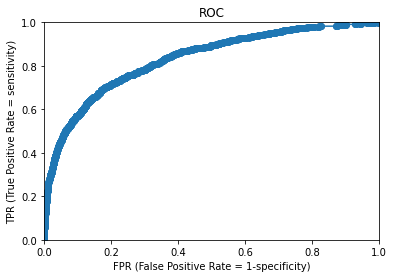

In [128]:
plt.plot(fpr, tpr, '-o')
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [133]:
roc_auc_score(y=='Toxic', scores)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: ignored